In [1]:
import json, os, pickle, random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima,FakeGuadalupe,FakeSherbrooke,FakePrague,FakeCairo
from blackwater.data.utils import get_backend_properties_v1
from qiskit.circuit.random import random_circuit
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [3]:
# 设置理想和含噪声的后端参数
from qiskit.providers.fake_provider import FakeGuadalupe,FakeMontreal,FakeCairo,FakeMumbai,FakeSydney,FakeToronto
backend_list = []
properties_dict = {}
run_config_ideal_list = []
run_config_noisy_list = []
backend = FakeGuadalupe()
backend_list.append(backend)
backend = FakeMontreal()
backend_list.append(backend)
backend = FakeCairo()
backend_list.append(backend)
backend = FakeMumbai()
backend_list.append(backend)
backend = FakeSydney()
backend_list.append(backend)
backend = FakeToronto()
backend_list.append(backend)
for backend in backend_list:
    properties = get_backend_properties_v1(backend)
    backend_name = backend.name()
    properties_dict[backend_name] = properties
    backend_ideal = QasmSimulator() # Noiseless
    backend_noisy = AerSimulator.from_backend(backend)
    shots = 100000
    run_config_ideal = {'shots': shots, 'backend': backend_ideal, 'name': 'ideal'}
    run_config_ideal_list.append(run_config_ideal)
    run_config_noisy = {'shots': shots, 'backend': backend_noisy, 'name': 'noisy'}
    run_config_noisy_list.append(run_config_noisy)

In [4]:
MQT_test_list = ['ae_indep_qiskit','ghz_indep_qiskit','graphstate_indep_qiskit','qaoa_indep_qiskit','qpeexact_indep_qiskit','qpeinexact_indep_qiskit','vqe_indep_qiskit','wstate_indep_qiskit']

In [5]:
# 将HLD_list追加保存到json文件
def save_HLD(model_name,HLD_list):
    # 定义两个字典
    HLD_dict = {}
    HLD_dict[model_name] = HLD_list
    # 读取已有的 JSON 文件内容
    with open('./multi_backend_model_data/HLD.json', 'r') as file:
        data = json.load(file)

    # 将第二个字典追加到已有内容中
    data.update(HLD_dict)

    # 将更新后的内容写回 JSON 文件
    with open('./multi_backend_model_data/HLD.json', 'w') as file:
        json.dump(data, file)


# 将2个字典互补
def complement_dicts(dict1, dict2):
    # 找到两个字典的并集键集合
    all_keys = set(dict1.keys()) | set(dict2.keys())

    # 在每个字典中补足缺失的键值对
    for key in all_keys:
        dict1.setdefault(key, 0)
        dict2.setdefault(key, 0)

    return dict1, dict2


def chunk_list(input_list, chunk_size):
    return [input_list[i:i + chunk_size] for i in range(0, len(input_list), chunk_size)]

# 加载训练和测试数据文件
def load_circuits(data_files, f_ext='.pk'):
    backend_name_list = []
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals_1 = []
    noisy_exp_vals_2 = []
    noisy_exp_vals_3 = []
    for data_file in data_files:
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                # 获取当前线路对应的后端，这个后端名称可以从数据文件的名字获得
                data_backend_name = os.path.basename(data_file).split('.')[0].split('_')[0] + '_' + os.path.basename(data_file).split('.')[0].split('_')[1]
                backend_name_list.append(data_backend_name)
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals_1.append(entry['noisy_exp_values_1'])
                noisy_exp_vals_2.append(entry['noisy_exp_values_2'])
                noisy_exp_vals_3.append(entry['noisy_exp_values_3'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                # 获取当前线路对应的后端，这个后端名称可以从数据文件的名字获得
                data_backend_name = os.path.basename(data_file).split('.')[0].split('_')[0] + '_' + os.path.basename(data_file).split('.')[0].split('_')[1]
                backend_name_list.append(data_backend_name)
                circuits.append(entry['circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals_1.append(entry['noisy_exp_values_1'])
                noisy_exp_vals_2.append(entry['noisy_exp_values_2'])
                noisy_exp_vals_3.append(entry['noisy_exp_values_3'])
    return circuits, ideal_exp_vals, noisy_exp_vals_1,noisy_exp_vals_2,noisy_exp_vals_3,backend_name_list


# 获取数组中前25%大的数据和第25%-50%大的数据
def get_25_50(arr):
    arr.sort()  # 对数组进行排序
    quarter = len(arr) // 4  # 计算数组长度的四分之一
    first_25_percent = arr[-quarter:]  # 获取数组中前25%大的数据
    second_25_to_50_percent = arr[-2*quarter:-quarter]  # 获取数组中第25%-50%大的数据
    return first_25_percent, second_25_to_50_percent

# 将一个形状如tensor([0.2600, 0.0900])的数据按照第一个为state，第二个位qubits转换为对应的二进制数
def get_state(obs_tensor):
    state = int(obs_tensor[0] * 100)
    qubit = int(obs_tensor[1] * 100)
    state_binary = format(state, '0' + str(qubit) + 'b')
    return state_binary

# 海灵格距离
def HellingerDistance(p, q):
    import numpy as np
    p = np.array(p)
    q = np.array(q)
    return  np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q))**2)) / np.sqrt(2)

# JS散度
def JensenShannonDivergence(p, q):
    p = np.array(p)
    q = np.array(q)
    M = (p + q)/2
    return 0.5 * np.sum(p*np.log(p/M)) + 0.5 * np.sum(q*np.log(q/M))

# MSE
def get_MSE(p,q):
    p = np.array(p)
    q = np.array(q)
    mse = np.mean((p - q) ** 2)
    return mse    

# 获取某一数组的前百分之25元素的索引返回，如果不足1则返回最大元素的索引
def get_top25_percent_indices(arr):
    n = len(arr)
    k = max(int(0.25 * n), 1)  # 获取前25%的数量，确保至少返回一个索引
    if k >= n:  # 如果前25%的数量大于等于数组长度
        return [np.argmax(arr)]  # 返回最大元素的索引
    else:
        indices = np.argpartition(arr, -k)[-k:]  # 获取前25%值对应的索引
        return indices

# 获取某一数组的前百分之50元素的索引返回，如果不足1则返回最大元素的索引
def get_top50_percent_indices(arr):
    n = len(arr)
    k = max(int(0.5 * n), 1)  # 获取前50%的数量，确保至少返回一个索引
    if k >= n:  # 如果前25%的数量大于等于数组长度
        return [np.argmax(arr)]  # 返回最大元素的索引
    else:
        indices = np.argpartition(arr, -k)[-k:]  # 获取前25%值对应的索引
        return indices


# 获取数组中值不为0的元素的索引
def get_not_0_index(arr):
    indices = [i for i, value in enumerate(arr) if value != 0]
    return indices

# 获取线路中单比特和2比特门的个数,线路深度和宽度
def get_circuit_info(trans_circuit):
    dag = circuit_to_dag(trans_circuit)
    Num_1Q_Gates = 0
    Num_2Q_Gates = 0
    circuit_depth = trans_circuit.depth()
    circuit_weith = trans_circuit.width()
    circuit_info = []
    for node in dag.nodes():
            try:
                if node.qargs:
                    if node.name=="barrier" or node.name=="measure":
                        continue
                    if len(node.qargs)==1:
                        Num_1Q_Gates+=1
                    else:
                        Num_2Q_Gates+=1
            except:
                pass
    # circuit_info.append(Num_1Q_Gates)
    # circuit_info.append(Num_2Q_Gates)
    circuit_info.append(circuit_depth)
    circuit_info.append(circuit_weith)
    return circuit_info

# 获取num在arr中从小到大排序之后的位次
def find_sorted_position(arr, num):
    sorted_arr = sorted(arr)
    return sorted_arr.index(num) + 1


# 求得字典的key的合集之后根据新的key的集合更新字典并返回
def update_noisy_dict(dict_1,dict_2,dict_3):
    # 求取所有字典的key的合集
    dicts = [dict_1,dict_2,dict_3]
    keys = set().union(*dicts)
    
    # 更新每个字典
    for d in dicts:
        for key in keys:
            if key not in d:
                d[key] = 0
    dict_1 = dicts[0]
    dict_2 = dicts[1]
    dict_3 = dicts[2]
    return dict_1,dict_2,dict_3

# 获取一个量子线路的门集统计信息
def get_gate_info(qc):
    gate_info = {}  # 用于存储门的信息
    qubits_used = set()  # 用于存储使用过的比特索引的集合
    two_qubits_gate = ['cx', 'cz', 'cy']
    for instruction in qc._data:
        op_name = instruction.operation.name
        if op_name not in gate_info:
            gate_info[op_name] = {}  # 初始化门的信息字典
        qubits = instruction.qubits
        if op_name in ['measure', 'barrier']:
            continue  # 跳过测量和 barrier 操作
        for qubit in qubits:
            qubits_used.add(qubit.index)  # 将比特索引添加到集合中
        if op_name in two_qubits_gate:
            control, target = qubits
            pair = (control.index, target.index)  # 控制-目标比特对
            if pair not in gate_info[op_name]:
                gate_info[op_name][pair] = 1  # 若该控制-目标比特对尚未记录，则初始化为1
            else:
                gate_info[op_name][pair] += 1  # 若已记录过该控制-目标比特对，则次数加1
        else:
            qubit_index = qubits[0].index  # 获取操作作用的比特索引
            if qubit_index not in gate_info[op_name]:
                gate_info[op_name][qubit_index] = 1  # 若该比特索引尚未记录，则初始化为1
            else:
                gate_info[op_name][qubit_index] += 1  # 若已记录过该比特索引，则次数加1
    qubits_used = sorted(list(qubits_used))  # 将集合转换为排序后的列表
    gate_info['qubits_num'] = qubits_used  # 添加比特数组到返回的字典中
    return gate_info

# 计算一个量子线路的error_info
def get_error_info(properties, gate_info):
    error_info = {}  # 存储门的错误信息
    # 初始化
    for gate in properties['gates_set']:
        error_info[gate] = 0
    for gate in gate_info:
        if gate in properties['gates_set']:
            error_sum = 0
            for qubit, count in gate_info[gate].items():
                if isinstance(qubit, tuple):  # 对于两比特门
                    control, target = qubit
                    gate_name = gate + f'_{control}_{target}'  # 按照惯例拼接门的名称
                    gate_error = properties['gate_props'][gate_name]['gate_error']  # 获取门的错误率
                    error_sum += count * gate_error
                else:  # 对于单比特门
                    gate_name = gate + f'_{qubit}'
                    gate_error = properties['gate_props'][gate_name]['gate_error']  # 获取门的错误率
                    error_sum += count * gate_error
            error_info[gate] = error_sum
    
    # 计算使用过的qubits的readout_error的和
    readout_error_sum = sum(properties['qubits_props'][qubit]['readout_error'] for qubit in gate_info['qubits_num'])

    error_info['readout_error'] = readout_error_sum
    error_info.pop('id')
    error_info.pop('reset')
    error_info.pop('rz')
    
    
    return error_info

In [6]:
import qiskit.circuit.random
import torch, random
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import numpy as np
import json, os, pickle
from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from qiskit import QuantumCircuit
from scipy import stats

def binary_to_decimal(binary_string):
    decimal_number = int(binary_string, 2)
    return decimal_number

def count_lenth(list):
    total_elements = 0
    for dict_i in list:
        total_elements += len(dict_i)
    return total_elements

def count_gates_by_rotation_angle(circuit, bin_size):
    angles = []
    for instr, qargs, cargs in circuit.data:
        if instr.name in ['rx', 'ry', 'rz'] and len(qargs) == 1:
            angles += [float(instr.params[0])]
    bin_edges = np.arange(-2 * np.pi, 2 * np.pi + bin_size, bin_size)
    counts, _ = np.histogram(angles, bins=bin_edges)
    bin_labels = [f"{left:.2f} to {right:.2f}" for left, right in zip(bin_edges[:-1], bin_edges[1:])]
    angle_bins = {label: count for label, count in zip(bin_labels, counts)}
    return list(angle_bins.values())


def recursive_dict_loop(my_dict, parent_key=None, out=None, target_key1=None, target_key2=None):
    if out is None: out = []

    for key, val in my_dict.items():
        if isinstance(val, dict):
            recursive_dict_loop(val, key, out, target_key1, target_key2)
        else:
            if parent_key and target_key1 in str(parent_key) and key == target_key2:
                out += [val]
    return out or 0.

def encode_data(circuits,backend_name_list,properties_dict, ideal_vals_list, noisy_vals_list_1,noisy_vals_list_2,noisy_vals_list_3):
    gates_set = sorted([ 'sx', 'x', 'cx','rz'])
    backend_code = {'fake_guadalupe':1,'fake_montreal':2,'fake_cairo':3,'fake_mumbai':4,'fake_sydney':5,'fake_toronto':6}
    bin_size = 0.5 * np.pi
    num_angle_bins = int(np.ceil(4 * np.pi / bin_size))
    for i,circ in enumerate(circuits):
        noisy_vals_list_1[i],noisy_vals_list_2[i],noisy_vals_list_3[i] = update_noisy_dict(noisy_vals_list_1[i],noisy_vals_list_2[i],noisy_vals_list_3[i])
    X_lenth = count_lenth(noisy_vals_list_1)

    X = torch.zeros([X_lenth, 1 + 1 + len(gates_set) + num_angle_bins +2 + 3 + 1 + 2])

    error_slice = slice(0, 1)
    backend_code_slice = slice(1,1+1)
    gate_counts_slice = slice(1+1, 1+1+len(gates_set))
    angle_bins_slice = slice(1+1+len(gates_set), 1+1+len(gates_set)+num_angle_bins)
    gate_info_slice = slice(1+1+len(gates_set)+num_angle_bins,1+1+len(gates_set)+num_angle_bins+2)
    exp_val_slice = slice(1+1+len(gates_set)+num_angle_bins+2, 1+1+len(gates_set)+num_angle_bins+2+3)
    std_slice = slice(1+1+len(gates_set)+num_angle_bins+2+3,1+1+len(gates_set)+num_angle_bins+2+3+1)
    state_slice = slice(1+1+len(gates_set)+num_angle_bins+2+3+1,1+1+len(gates_set)+num_angle_bins+2+3+1+2)

    x_count = 0
    ideal_vals = []
    for i, circ in enumerate(circuits):
        gate_counts_all = circ.count_ops()
        backend_name = backend_name_list[i]
        backend_code_i = backend_code[backend_name]
        properties = properties_dict[backend_name]
        circuit_info = get_circuit_info(circ)
        gate_counts = count_gates_by_rotation_angle(circ, bin_size)
        noisy_vals_1 = noisy_vals_list_1[i]
        noisy_vals_2 = noisy_vals_list_2[i]
        noisy_vals_3 = noisy_vals_list_3[i]
        gate_info = get_gate_info(circ)
        error_info = get_error_info(properties,gate_info)
        error_info = sum(np.array(list(error_info.values())))
        for noisy_state in noisy_vals_1.keys():
            obs = []
            state = binary_to_decimal(noisy_state)*0.01
            qubits = len(noisy_state)*0.01
            obs.append(state)
            obs.append(qubits)
            noisy_vals = [noisy_vals_1[noisy_state],noisy_vals_2[noisy_state],noisy_vals_3[noisy_state]]
            std_noisy =  stats.tstd(noisy_vals)
            # 当前后端的编号
            X[x_count,backend_code_slice] = torch.tensor(backend_code_i)
            # 3次含噪声的值的标准差
            X[x_count,std_slice] = torch.tensor(std_noisy)
            # 门错误统计信息
            X[x_count,error_slice] = torch.tensor(error_info)
            # 线路信息编码，4维
            X[x_count,gate_info_slice] = torch.tensor(circuit_info)*0.01
            # 状态编码，二维
            X[x_count, state_slice] = torch.tensor(obs, dtype=torch.float)
            # 对应状态解的编码，3维,因为线路在含噪声的情况下运行了3次
            X[x_count, exp_val_slice] = torch.tensor(noisy_vals,dtype=torch.float)
            # 将对应的理想解按X的噪声解顺序加到y中
            if noisy_state in ideal_vals_list[i].keys():
                ideal_vals.append(ideal_vals_list[i][noisy_state])
            else:
                ideal_vals.append(0)
            X[x_count, gate_counts_slice] = torch.tensor([gate_counts_all.get(key, 0) for key in gates_set]) * 0.01  # put it in the same order of magnitude as the expectation values
            X[x_count, angle_bins_slice] = torch.tensor(gate_counts) * 0.01  # put it in the same order of magnitude as the expectation values
            x_count += 1
    
    y = torch.tensor(ideal_vals, dtype=torch.float32)
    
    return X, y


In [7]:
import qiskit.circuit.random
import torch, random
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import numpy as np
import json, os, pickle
from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from qiskit import QuantumCircuit
from scipy import stats

def binary_to_decimal(binary_string):
    decimal_number = int(binary_string, 2)
    return decimal_number

def count_lenth(list):
    total_elements = 0
    for dict_i in list:
        total_elements += len(dict_i)
    return total_elements

def count_gates_by_rotation_angle(circuit, bin_size):
    angles = []
    for instr, qargs, cargs in circuit.data:
        if instr.name in ['rx', 'ry', 'rz'] and len(qargs) == 1:
            angles += [float(instr.params[0])]
    bin_edges = np.arange(-2 * np.pi, 2 * np.pi + bin_size, bin_size)
    counts, _ = np.histogram(angles, bins=bin_edges)
    bin_labels = [f"{left:.2f} to {right:.2f}" for left, right in zip(bin_edges[:-1], bin_edges[1:])]
    angle_bins = {label: count for label, count in zip(bin_labels, counts)}
    return list(angle_bins.values())


def recursive_dict_loop(my_dict, parent_key=None, out=None, target_key1=None, target_key2=None):
    if out is None: out = []

    for key, val in my_dict.items():
        if isinstance(val, dict):
            recursive_dict_loop(val, key, out, target_key1, target_key2)
        else:
            if parent_key and target_key1 in str(parent_key) and key == target_key2:
                out += [val]
    return out or 0.

def encode_data_with_out_feature(circuits,backend_name_list,properties_dict, ideal_vals_list, noisy_vals_list_1,noisy_vals_list_2,noisy_vals_list_3):
    # circuits是量子线路，properties是后端属性，ideal_exp_vals和noisy_exp_vals分别是理想和含噪声的状态解(其数据类型是数组，数组元素是字典，每一个字典是一条线路的状态解)

    # gates_set = sorted(['reset', 'rz', 'sx', 'x', 'id', 'cx'])     # must sort!
    # noisy_gates_set = sorted([ 'sx', 'x',  'cx', 'rz'])
    gates_set = sorted([ 'sx', 'x', 'cx','rz'])
    # 首先更新含噪声的3个数组字典
    for i,circ in enumerate(circuits):
        noisy_vals_list_1[i],noisy_vals_list_2[i],noisy_vals_list_3[i] = update_noisy_dict(noisy_vals_list_1[i],noisy_vals_list_2[i],noisy_vals_list_3[i])
    # 为每一个含噪声的状态解都要创建一行数据
    X_lenth = count_lenth(noisy_vals_list_1)

    X = torch.zeros([X_lenth,  len(gates_set)+2+3])

    # error_slice = slice(0, 1)
    # backend_code_slice = slice(0,1)
    gate_counts_slice = slice(0, len(gates_set))
    # angle_bins_slice = slice(1+len(gates_set), 1+len(gates_set)+num_angle_bins)
    # exp_val_slice = slice(len(vec)+len(gates_set)+num_angle_bins, len(vec)+len(gates_set)+num_angle_bins+num_qubits)
    # 线路状态信息
    gate_info_slice = slice(len(gates_set),len(gates_set)+2)
    # 当前状态的概率值
    exp_val_slice = slice(len(gates_set)+2, len(gates_set)+2+3)
    # 当前状态的概率值的波动程度，标准差
    # std_slice = slice(1+len(gates_set)+num_angle_bins+2+3,1+len(gates_set)+num_angle_bins+2+3+1)
    # 二进制的状态编码转换为一个十进制数和对应的量子比特数
    # state_slice = slice(1+len(gates_set)+num_angle_bins+2+3+1,1+len(gates_set)+num_angle_bins+2+3+1+2)
    # meas_basis_slice = slice(len(vec)+len(gates_set)+num_angle_bins+1+2, len(X[0]))
    # 当前线路对应的运行后端的编码

    x_count = 0
    ideal_vals = []
    for i, circ in enumerate(circuits):
        gate_counts_all = circ.count_ops()
        # 同一条线路的这个数据是相等的，所以这里统一赋值
        # backend_name = backend_name_list[i]
        # backend_code_i = backend_code[backend_name]
        # properties = properties_dict[backend_name]
        circuit_info = get_circuit_info(circ)
        # gate_counts = count_gates_by_rotation_angle(circ, bin_size)
        noisy_vals_1 = noisy_vals_list_1[i]
        noisy_vals_2 = noisy_vals_list_2[i]
        noisy_vals_3 = noisy_vals_list_3[i]
        # gate_info = get_gate_info(circ)
        # error_info = get_error_info(properties,gate_info)
        # error_info = sum(np.array(list(error_info.values())))
        for noisy_state in noisy_vals_1.keys():
            # obs = []
            # state = binary_to_decimal(noisy_state)*0.01
            # qubits = len(noisy_state)*0.01
            # obs.append(state)
            # obs.append(qubits)
            noisy_vals = [noisy_vals_1[noisy_state],noisy_vals_2[noisy_state],noisy_vals_3[noisy_state]]
            # std_noisy =  stats.tstd(noisy_vals)
            # 当前后端的编号
            # X[x_count,backend_code_slice] = torch.tensor(backend_code_i)
            # 3次含噪声的值的标准差
            # X[x_count,std_slice] = torch.tensor(std_noisy)
            # 门错误统计信息
            # X[x_count,error_slice] = torch.tensor(error_info)
            # 线路信息编码，4维
            X[x_count,gate_info_slice] = torch.tensor(circuit_info)*0.01
            # 状态编码，二维
            # X[x_count, state_slice] = torch.tensor(obs, dtype=torch.float)
            # 对应状态解的编码，3维,因为线路在含噪声的情况下运行了3次
            X[x_count, exp_val_slice] = torch.tensor(noisy_vals,dtype=torch.float)
            # 将对应的理想解按X的噪声解顺序加到y中
            if noisy_state in ideal_vals_list[i].keys():
                ideal_vals.append(ideal_vals_list[i][noisy_state])
            else:
                ideal_vals.append(0)
            X[x_count, gate_counts_slice] = torch.tensor([gate_counts_all.get(key, 0) for key in gates_set]) * 0.01  # put it in the same order of magnitude as the expectation values
            # X[x_count, angle_bins_slice] = torch.tensor(gate_counts) * 0.01  # put it in the same order of magnitude as the expectation values
            x_count += 1
    
    y = torch.tensor(ideal_vals, dtype=torch.float32)
    
    return X, y


In [8]:
gates_set = sorted([ 'sx', 'x', 'cx','rz'])
print(gates_set)

['cx', 'rz', 'sx', 'x']


In [9]:
import glob
def get_test_loaders(test_circuits,backend_name_list, test_ideal_vals_list, test_noisy_vals_list_1,test_noisy_vals_list_2,test_noisy_vals_list_3,properties_dict,BATCH_SIZE = 32):
    # 这个函数为每一条线路都生成一个test_loader，这样在测试的时候可以把同一条线路的结果放在一起进行处理
    Test_loaders = []
    X_test = []
    y_test = []
    for i,single_circuit in enumerate(test_circuits):
        single_circuit = [single_circuit]
        single_ideal = [test_ideal_vals_list[i]]
        single_noisy_1 = [test_noisy_vals_list_1[i]]
        single_noisy_2 = [test_noisy_vals_list_2[i]]
        single_noisy_3 = [test_noisy_vals_list_3[i]]
        backend_name = [backend_name_list[i]]
        # *******************
        # x_test_i,y_test_i = encode_data(single_circuit,properties,single_ideal,single_noisy_1,single_noisy_2,single_noisy_3)
        x_test_i, y_test_i = encode_data(single_circuit,backend_name,properties_dict,single_ideal,single_noisy_1,single_noisy_2,single_noisy_3)
        test_dataset_i = TensorDataset(torch.Tensor(x_test_i), torch.Tensor(y_test_i))
        test_loader_i = DataLoader(test_dataset_i, batch_size=BATCH_SIZE*1000, shuffle=False)
        x_test_i = pd.DataFrame(x_test_i)
        y_test_i = pd.DataFrame(y_test_i)
        Test_loaders.append(test_loader_i)
        X_test.append(x_test_i)
        y_test.append(y_test_i)
    return Test_loaders,X_test,y_test
            
def get_test_data(test_paths):
    # 参数就是一个路径的数组
    # test_paths = glob.glob(f"{test_path}/dataset_**.pk")
    test_circuits, test_ideal_vals_list, test_noisy_vals_list_1,test_noisy_vals_list_2,test_noisy_vals_list_3,backend_name_list = load_circuits(test_paths,f_ext = '.pk')
    shots = sum(test_ideal_vals_list[0].values())
    test_ideal_vals_list = [{k: v / shots for k, v in d.items()} for d in test_ideal_vals_list]
    test_noisy_vals_list_1 = [{k: v / shots for k, v in d.items()} for d in test_noisy_vals_list_1]
    test_noisy_vals_list_2 = [{k: v / shots for k, v in d.items()} for d in test_noisy_vals_list_2]
    test_noisy_vals_list_3 = [{k: v / shots for k, v in d.items()} for d in test_noisy_vals_list_3]
    test_loader_list,X_test_list, y_test_list = get_test_loaders(test_circuits, backend_name_list,test_ideal_vals_list, test_noisy_vals_list_1,test_noisy_vals_list_2,test_noisy_vals_list_3,properties_dict)
    return test_loader_list,X_test_list, y_test_list

def get_train_data(train_path):
    BATCH_SIZE = 32
    train_paths = glob.glob(f"{train_path}/**.pk")
    train_circuits, train_ideal_vals_list, train_noisy_vals_list_1,train_noisy_vals_list_2,train_noisy_vals_list_3,backend_name_list = load_circuits(train_paths,f_ext = '.pk')
    # 转换为概率值
    shots = sum(train_ideal_vals_list[0].values())
    train_ideal_vals_list = [{k: v / shots for k, v in d.items()} for d in train_ideal_vals_list]
    train_noisy_vals_list_1 = [{k: v / shots for k, v in d.items()} for d in train_noisy_vals_list_1]
    train_noisy_vals_list_2 = [{k: v / shots for k, v in d.items()} for d in train_noisy_vals_list_2]
    train_noisy_vals_list_3 = [{k: v / shots for k, v in d.items()} for d in train_noisy_vals_list_3]
    ######################################
    X_train, y_train = encode_data(train_circuits,backend_name_list,properties_dict, train_ideal_vals_list, train_noisy_vals_list_1,train_noisy_vals_list_2,train_noisy_vals_list_3)
    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    X_train = pd.DataFrame(X_train)#.iloc[:, -4:]
    y_train = pd.DataFrame(y_train)
    return train_loader,X_train,y_train

In [6]:
import glob
def get_test_loaders_other_model(test_circuits,backend_name_list, test_ideal_vals_list, test_noisy_vals_list_1,test_noisy_vals_list_2,test_noisy_vals_list_3,properties_dict,BATCH_SIZE = 32):
    # 这个函数为每一条线路都生成一个test_loader，这样在测试的时候可以把同一条线路的结果放在一起进行处理
    # Test_loaders = []
    X_test = []
    y_test = []
    for i,single_circuit in enumerate(test_circuits):
        single_circuit = [single_circuit]
        single_ideal = [test_ideal_vals_list[i]]
        single_noisy_1 = [test_noisy_vals_list_1[i]]
        single_noisy_2 = [test_noisy_vals_list_2[i]]
        single_noisy_3 = [test_noisy_vals_list_3[i]]
        backend_name = [backend_name_list[i]]
        # *******************
        # x_test_i,y_test_i = encode_data(single_circuit,properties,single_ideal,single_noisy_1,single_noisy_2,single_noisy_3)
        x_test_i, y_test_i = encode_data(single_circuit,backend_name,properties_dict,single_ideal,single_noisy_1,single_noisy_2,single_noisy_3)
        # test_dataset_i = TensorDataset(torch.Tensor(x_test_i), torch.Tensor(y_test_i))
        # test_loader_i = DataLoader(test_dataset_i, batch_size=BATCH_SIZE*1000, shuffle=False)
        # x_test_i = pd.DataFrame(x_test_i)
        # y_test_i = pd.DataFrame(y_test_i)
        # Test_loaders.append(test_loader_i)
        X_test.append(x_test_i)
        y_test.append(y_test_i)
    return X_test,y_test
            
def get_test_data_other_model(test_paths):
    # 参数就是一个路径的数组
    # test_paths = glob.glob(f"{test_path}/dataset_**.pk")
    test_circuits, test_ideal_vals_list, test_noisy_vals_list_1,test_noisy_vals_list_2,test_noisy_vals_list_3,backend_name_list = load_circuits(test_paths,f_ext = '.pk')
    shots = sum(test_ideal_vals_list[0].values())
    test_ideal_vals_list = [{k: v / shots for k, v in d.items()} for d in test_ideal_vals_list]
    test_noisy_vals_list_1 = [{k: v / shots for k, v in d.items()} for d in test_noisy_vals_list_1]
    test_noisy_vals_list_2 = [{k: v / shots for k, v in d.items()} for d in test_noisy_vals_list_2]
    test_noisy_vals_list_3 = [{k: v / shots for k, v in d.items()} for d in test_noisy_vals_list_3]
    X_test_list, y_test_list = get_test_loaders_other_model(test_circuits, backend_name_list,test_ideal_vals_list, test_noisy_vals_list_1,test_noisy_vals_list_2,test_noisy_vals_list_3,properties_dict)
    return X_test_list, y_test_list

def get_train_data_other_model(train_path):
    BATCH_SIZE = 32
    train_paths = glob.glob(f"{train_path}/**.pk")
    train_circuits, train_ideal_vals_list, train_noisy_vals_list_1,train_noisy_vals_list_2,train_noisy_vals_list_3,backend_name_list = load_circuits(train_paths,f_ext = '.pk')
    # 转换为概率值
    shots = sum(train_ideal_vals_list[0].values())
    train_ideal_vals_list = [{k: v / shots for k, v in d.items()} for d in train_ideal_vals_list]
    train_noisy_vals_list_1 = [{k: v / shots for k, v in d.items()} for d in train_noisy_vals_list_1]
    train_noisy_vals_list_2 = [{k: v / shots for k, v in d.items()} for d in train_noisy_vals_list_2]
    train_noisy_vals_list_3 = [{k: v / shots for k, v in d.items()} for d in train_noisy_vals_list_3]
    ######################################
    X_train, y_train = encode_data(train_circuits,backend_name_list,properties_dict, train_ideal_vals_list, train_noisy_vals_list_1,train_noisy_vals_list_2,train_noisy_vals_list_3)
    # train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    # train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    # X_train = pd.DataFrame(X_train)#.iloc[:, -4:]
    # y_train = pd.DataFrame(y_train)
    return X_train,y_train

In [10]:
train_path = './multi_backend_model_data/train_data'
train_loader,X_train,y_train = get_train_data(train_path)

C:\Users\30806\AppData\Local\Temp\ipykernel_62068\1317806438.py:188: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  qubits_used.add(qubit.index)  # 将比特索引添加到集合中
C:\Users\30806\AppData\Local\Temp\ipykernel_62068\1317806438.py:197: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  qubit_index = qubits[0].index  # 获取操作作用的比特索引
C:\Users\30806\AppData\Local\Temp\ipykernel_62068\1317806438.py:191: Depr

In [11]:
print(X_train)

              0    1     2     3     4     5    6    7     8     9   ...  \
0       0.144813  3.0  0.12  0.24  0.14  0.03  0.0  0.0  0.03  0.08  ...   
1       0.144813  3.0  0.12  0.24  0.14  0.03  0.0  0.0  0.03  0.08  ...   
2       0.144813  3.0  0.12  0.24  0.14  0.03  0.0  0.0  0.03  0.08  ...   
3       0.144813  3.0  0.12  0.24  0.14  0.03  0.0  0.0  0.03  0.08  ...   
4       0.144813  3.0  0.12  0.24  0.14  0.03  0.0  0.0  0.03  0.08  ...   
...          ...  ...   ...   ...   ...   ...  ...  ...   ...   ...  ...   
473870  2.935955  6.0  0.96  1.26  0.70  0.07  0.0  0.0  0.34  0.31  ...   
473871  2.935955  6.0  0.96  1.26  0.70  0.07  0.0  0.0  0.34  0.31  ...   
473872  2.935955  6.0  0.96  1.26  0.70  0.07  0.0  0.0  0.34  0.31  ...   
473873  2.935955  6.0  0.96  1.26  0.70  0.07  0.0  0.0  0.34  0.31  ...   
473874  2.935955  6.0  0.96  1.26  0.70  0.07  0.0  0.0  0.34  0.31  ...   

          12    13    14    15       16       17       18        19    20  \
0       0.

In [180]:
train_path = './multi_backend_model_data/train_data'
X_train,y_train = get_train_data_other_model(train_path)

NameError: name 'get_train_data_other_model' is not defined

In [12]:
# 按比特数加载数据
# 按比特数加载测试数据
def get_test_data_by_qubit(test_path):
    test_paths = glob.glob(f"{test_path}/**.pk")
    # 将文件列表按照
    test_paths = sorted(test_paths,key=lambda x: int(x.split('_')[-2]))
    # print(test_paths)
    # 6种后端
    test_paths_split_by_qubits = chunk_list(test_paths,6)
    # print(test_paths_split_by_qubits)
    test_loader_lists = []
    X_test_lists = []
    y_test_lists = []
    # suanfa_name = []
    for qubits_paths in test_paths_split_by_qubits:
        # print(qubits_paths)
        # 获取算法名字
        # base_name =  os.path.basename(paths)
        # suanfa_name.append(os.path.splitext(base_name)[0])
        test_loader_list,X_test_list, y_test_list = get_test_data(qubits_paths)
        test_loader_lists.append(test_loader_list)
        X_test_lists.append(X_test_list)
        y_test_lists.append(y_test_list)
    return test_loader_lists,X_test_lists,y_test_lists

In [13]:
test_path = './multi_backend_model_data/MQT_test'
test_loader_lists,X_test_lists,y_test_lists = get_test_data_by_qubit(test_path)

C:\Users\30806\AppData\Local\Temp\ipykernel_62068\1317806438.py:188: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  qubits_used.add(qubit.index)  # 将比特索引添加到集合中
C:\Users\30806\AppData\Local\Temp\ipykernel_62068\1317806438.py:197: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  qubit_index = qubits[0].index  # 获取操作作用的比特索引
C:\Users\30806\AppData\Local\Temp\ipykernel_62068\1317806438.py:191: Depr

In [14]:
print(X_test_lists)

[[          0    1     2     3     4     5    6     7     8     9   ...   12  \
0   0.287046  3.0  0.32  0.44  0.22  0.01  0.0  0.03  0.07  0.09  ...  0.0   
1   0.287046  3.0  0.32  0.44  0.22  0.01  0.0  0.03  0.07  0.09  ...  0.0   
2   0.287046  3.0  0.32  0.44  0.22  0.01  0.0  0.03  0.07  0.09  ...  0.0   
3   0.287046  3.0  0.32  0.44  0.22  0.01  0.0  0.03  0.07  0.09  ...  0.0   
4   0.287046  3.0  0.32  0.44  0.22  0.01  0.0  0.03  0.07  0.09  ...  0.0   
5   0.287046  3.0  0.32  0.44  0.22  0.01  0.0  0.03  0.07  0.09  ...  0.0   
6   0.287046  3.0  0.32  0.44  0.22  0.01  0.0  0.03  0.07  0.09  ...  0.0   
7   0.287046  3.0  0.32  0.44  0.22  0.01  0.0  0.03  0.07  0.09  ...  0.0   
8   0.287046  3.0  0.32  0.44  0.22  0.01  0.0  0.03  0.07  0.09  ...  0.0   
9   0.287046  3.0  0.32  0.44  0.22  0.01  0.0  0.03  0.07  0.09  ...  0.0   
10  0.287046  3.0  0.32  0.44  0.22  0.01  0.0  0.03  0.07  0.09  ...  0.0   
11  0.287046  3.0  0.32  0.44  0.22  0.01  0.0  0.03  0.07  0.

In [14]:
# 除随机森林以外的模型************************************
# 按比特数加载数据
# 按比特数加载测试数据
test_path = './multi_backend_model_data/test_data'
test_paths = glob.glob(f"{test_path}/**.pk")
# 将文件列表按照
test_paths = sorted(test_paths,key=lambda x: int(x.split('_')[-2]))
# print(test_paths)
# 6种后端
test_paths_split_by_qubits = chunk_list(test_paths,6)
# print(test_paths_split_by_qubits)
# test_loader_lists = []
X_test_lists = []
y_test_lists = []
# suanfa_name = []
for qubits_paths in test_paths_split_by_qubits:
    # print(qubits_paths)
    # 获取算法名字
    # base_name =  os.path.basename(paths)
    # suanfa_name.append(os.path.splitext(base_name)[0])
    X_test_list, y_test_list = get_test_data_other_model(qubits_paths)
    # test_loader_lists.append(test_loader_list)
    X_test_lists.append(X_test_list)
    y_test_lists.append(y_test_list)

NameError: name 'get_test_data_other_model' is not defined

In [14]:
# 保存模型
def save_model(rfr,model_name):
    save_path = f"./result"
    model_path = f"{save_path}/{model_name}"
    result_path = f"{model_path}/result"
    loss_path = model_path
    if not os.path.exists(model_path):
        os.mkdir(model_path)
    if not os.path.exists(result_path):
        os.mkdir(result_path)
    with open(f"{model_path}/{model_name}.pk", 'wb') as f:
        pickle.dump(rfr, f)
# 加载模型
def loade_model(model_name):
    save_path = f"./result"
    model_path = f"{save_path}/{model_name}"
    result_path = f"{model_path}/result"
    with open(f"{model_path}/{model_name}.pk", 'rb') as f:
        rfr = pickle.load(f)
    return rfr,result_path

In [16]:
# model training
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
fix_random_seed(0)
rfr = RandomForestRegressor(n_estimators=300)
rfr.fit(X_train, y_train)

random seed fixed to 0


c:\Users\30806\.conda\envs\test\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [22]:
QEMOS_model,result_path = loade_model('QEMOS')

In [44]:
def get_model_mited_test_other_model(model_name,test_loader_lists,save:bool):
    HLD_list = []
    count_right_list = []
    model,result_path = loade_model(model_name)
    for index_i_s,X_test_list in enumerate(X_test_lists):
        y_test_list = y_test_lists[index_i_s]
        qubits = index_i_s + 2
        HLD_mited_this_qubits = []
        # HLD_noisy_this_qubits = []
        count_right = 0
        count_all = 0
        for index_i,test_X in enumerate(X_test_list):
            # for test_X,test_y in test_loader:
            test_y = y_test_list[index_i]
            state_list = []
            ideal_list = []
            noisy_list = []
            mitigated_list = []
            result = {}
            out = model.predict(test_X.values)
            for obs, ideal, noisy, mitigated in zip(
                test_X.iloc[:,-2:].values,
                test_y.to_numpy(),
                test_X.iloc[:, -6:-3].values,
                out.tolist()
            ):
                ideal = ideal[0]
                noisy = noisy[0]
                mitigated = mitigated[0]
                obs = torch.tensor(obs)
                state = get_state(obs)
                state_list.append(state)
                ideal_list.append(ideal)
                noisy_list.append(np.mean(np.array(noisy)))
                mitigated_list.append(mitigated)
                
            mitigated_list = np.array(mitigated_list)
            # 先使得最小值为小于0的为0，再归一化
            mitigated_list = np.clip(mitigated_list, a_min=0, a_max=None)
            mitigated_list = mitigated_list/sum(mitigated_list)
            for ideal,noisy,mitigated in zip(ideal_list,noisy_list,mitigated_list):
                if(abs(ideal-mitigated)<abs(ideal-noisy)):
                    count_right +=1
                count_all += 1
            HLD_mited = HellingerDistance(ideal_list,mitigated_list)
            # HLD_noisy = HellingerDistance(ideal_list,noisy_list)
            HLD_mited_this_qubits.append(HLD_mited)
            # HLD_noisy_this_qubits.append(HLD_noisy)
            if (save):
                result['state'] = state_list
                result['ideal'] = ideal_list
                result['noisy'] = noisy_list
                result['mitigated'] = mitigated_list
                df = pd.DataFrame(result)
                file_name = f"{result_path}/{qubits}_qubits_{index_i}.xlsx"
                df.to_excel(file_name, index=False)
                print(f"结果已保存到 {file_name} 文件中")
        mean_HLD_mited_this_qubits = np.mean(np.array(HLD_mited_this_qubits))
        mitigated_right = count_right/count_all
        HLD_list.append(mean_HLD_mited_this_qubits)
        count_right_list.append(mitigated_right)
    return HLD_list,count_right_list
        # mean_HLD_noisy_this_qubits = np.mean(np.array(HLD_noisy_this_qubits))
                    

In [53]:
def get_model_mited_test_other_model_1(model_name,test_loader_lists,save:bool):
    HLD_list = []
    count_right_list = []
    model,result_path = loade_model(model_name)
    for index_i_s,X_test_list in enumerate(X_test_lists):
        y_test_list = y_test_lists[index_i_s]
        qubits = index_i_s + 2
        HLD_mited_this_qubits = []
        # HLD_noisy_this_qubits = []
        count_right = 0
        count_all = 0
        for index_i,test_X in enumerate(X_test_list):
            # for test_X,test_y in test_loader:
            test_y = y_test_list[index_i]
            state_list = []
            ideal_list = []
            noisy_list = []
            mitigated_list = []
            result = {}
            out = model.predict(test_X.values)
            for obs, ideal, noisy, mitigated in zip(
                test_X.iloc[:,-2:].values,
                test_y.to_numpy(),
                test_X.iloc[:, -6:-3].values,
                out.tolist()
            ):
                ideal = ideal[0]
                noisy = noisy[0]
                # mitigated = mitigated
                obs = torch.tensor(obs)
                state = get_state(obs)
                state_list.append(state)
                ideal_list.append(ideal)
                noisy_list.append(np.mean(np.array(noisy)))
                mitigated_list.append(mitigated)
                
            mitigated_list = np.array(mitigated_list)
            # 先使得最小值为小于0的为0，再归一化
            mitigated_list = np.clip(mitigated_list, a_min=0, a_max=None)
            mitigated_list = mitigated_list/sum(mitigated_list)
            for ideal,noisy,mitigated in zip(ideal_list,noisy_list,mitigated_list):
                if(abs(ideal-mitigated)<abs(ideal-noisy)):
                    count_right +=1
                count_all += 1
            HLD_mited = HellingerDistance(ideal_list,mitigated_list)
            # HLD_noisy = HellingerDistance(ideal_list,noisy_list)
            HLD_mited_this_qubits.append(HLD_mited)
            # HLD_noisy_this_qubits.append(HLD_noisy)
            if (save):
                result['state'] = state_list
                result['ideal'] = ideal_list
                result['noisy'] = noisy_list
                result['mitigated'] = mitigated_list
                df = pd.DataFrame(result)
                file_name = f"{result_path}/{qubits}_qubits_{index_i}.xlsx"
                df.to_excel(file_name, index=False)
                print(f"结果已保存到 {file_name} 文件中")
        mean_HLD_mited_this_qubits = np.mean(np.array(HLD_mited_this_qubits))
        mitigated_right = count_right/count_all
        HLD_list.append(mean_HLD_mited_this_qubits)
        count_right_list.append(mitigated_right)
    return HLD_list,count_right_list
        # mean_HLD_noisy_this_qubits = np.mean(np.array(HLD_noisy_this_qubits))
                    

In [35]:
# get circuit error of the test data after excute the model
def get_model_mited_test(model_name,test_loader_lists,save:bool):
    HLD_list = []
    count_right_list = []
    model,result_path = loade_model(model_name)
    for index_i_s,test_loader_list in enumerate(test_loader_lists):
        qubits = index_i_s + 2
        HLD_mited_this_qubits = []
        # HLD_noisy_this_qubits = []
        count_right = 0
        count_all = 0
        for index_i,test_loader in enumerate(test_loader_list):
            for test_X,test_y in test_loader:
                state_list = []
                ideal_list = []
                noisy_list = []
                mitigated_list = []
                result = {}
                out = model.predict(test_X[:, :])
                
                for obs, ideal, noisy, mitigated in zip(
                    test_X[:,-2:],
                    test_y.tolist(),
                    test_X[:, -6:-3].tolist(),
                    out.tolist()
                ):
                    state_list.append(get_state(obs))
                    ideal_list.append(ideal)
                    noisy_list.append(np.mean(np.array(noisy)))
                    mitigated_list.append(mitigated)
                    
                mitigated_list = np.array(mitigated_list)
                # 先使得最小值为小于0的为0，再归一化
                mitigated_list = np.clip(mitigated_list, a_min=0, a_max=None)
                mitigated_list = mitigated_list/sum(mitigated_list)
                for ideal,noisy,mitigated in zip(ideal_list,noisy_list,mitigated_list):
                    if(abs(ideal-mitigated)<abs(ideal-noisy)):
                        count_right +=1
                    count_all += 1
                HLD_mited = HellingerDistance(ideal_list,mitigated_list)
                # HLD_noisy = HellingerDistance(ideal_list,noisy_list)
                HLD_mited_this_qubits.append(HLD_mited)
                # HLD_noisy_this_qubits.append(HLD_noisy)
                if (save):
                    result['state'] = state_list
                    result['ideal'] = ideal_list
                    result['noisy'] = noisy_list
                    result['mitigated'] = mitigated_list
                    df = pd.DataFrame(result)
                    file_name = f"{result_path}/{qubits}_qubits_{index_i}.xlsx"
                    df.to_excel(file_name, index=False)
                    print(f"结果已保存到 {file_name} 文件中")
        mean_HLD_mited_this_qubits = np.mean(np.array(HLD_mited_this_qubits))
        mitigated_right = count_right/count_all
        HLD_list.append(mean_HLD_mited_this_qubits)
        count_right_list.append(mitigated_right)
    return HLD_list,count_right_list
        # mean_HLD_noisy_this_qubits = np.mean(np.array(HLD_noisy_this_qubits))
                    

In [36]:
def get_model_noisy_test(test_loader_lists):
    HLD_list = []
    # count_right_list = []
    for index_i_s,test_loader_list in enumerate(test_loader_lists):
        HLD_noisy_this_qubits = []
        for index_i,test_loader in enumerate(test_loader_list):
            for test_X,test_y in test_loader:
                state_list = []
                ideal_list = []
                noisy_list = []
                for obs, ideal, noisy in zip(
                    test_X[:,-2:],
                    test_y.tolist(),
                    test_X[:, -6:-3].tolist()
                ):
                    state_list.append(get_state(obs))
                    ideal_list.append(ideal)
                    noisy_list.append(np.mean(np.array(noisy)))
                HLD_noisy = HellingerDistance(ideal_list,noisy_list)
                HLD_noisy_this_qubits.append(HLD_noisy)
        mean_HLD_noisy_this_qubits = np.mean(np.array(HLD_noisy_this_qubits))
        HLD_list.append(mean_HLD_noisy_this_qubits)

    return HLD_list

                    

In [185]:
noisy = get_model_noisy_test(test_loader_lists)

In [199]:
noisy_MQT = get_model_noisy_test(test_loader_lists)

In [200]:
print(noisy_MQT)

[0.25013527947871234, 0.2971732244361071, 0.33786335027961895, 0.41041831114555194, 0.44143020246474163, 0.4640026819262009, 0.5186109440303035, 0.5484260635914189, 0.5820635414740505]


In [202]:
save_HLD('MQT_error',noisy_MQT)

In [186]:
print(noisy)

[0.07021440995446238, 0.10836854975852826, 0.17045777666706632, 0.2020546017188243, 0.2383514610669018, 0.2765195625311667, 0.3195854417216573, 0.32475208084688917, 0.35333038359336, 0.37255936251872107, 0.4200023208255368, 0.44924084722878727]


In [187]:
save_HLD('noisy_error',noisy)

In [47]:
qubits = [2,3,4,5,6,7,8,9,10,11,12,13]
save_HLD('Qubits',qubits)

In [18]:
Pccir_HLD = get_model_mited_test('forest_model_without_Pccir',test_loader_lists,save = False)

In [24]:
print(Pccir_HLD[1])
save_HLD('without_Pccir',Pccir_HLD[0])

[0.8377976190476191, 0.8209179834462002, 0.817511162880994, 0.7981050297349057, 0.7966963817514421, 0.78099173553719, 0.7619069336130494, 0.7599983758983312, 0.7031171311062615]


In [22]:
with open('./multi_backend_model_data/HLD.json', 'r') as f:
    data = json.load(f)
print(data['RF_MQT'])

[0.18963524529280554, 0.23862971138898662, 0.257488414435693, 0.352525564385253, 0.36756526473205725, 0.41116486430055005, 0.45967725577736945, 0.4837124275352785, 0.5094760526262108]


## QEMOS----random forest

#### ①use random forest to find the feature importance in the model

In [28]:
QEMOS_model,result_path = loade_model('QEMOS')

In [29]:
# 特征重要性
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
model_0 = QEMOS_model
X = X_train
import matplotlib.pyplot as plt
importances = model_0.feature_importances_
print(importances)
most_important_feature_index = importances.argmax()
most_important_feature_name = X.columns[most_important_feature_index]
feature_importance_without_most_important = np.delete(importances, most_important_feature_index)
remaining_features = X.columns[X.columns != most_important_feature_name]
remaining_feature_importance_df = pd.DataFrame({'Feature': remaining_features, 'Importance': feature_importance_without_most_important})
# plt.figure(figsize=(10, 8))
# sns.barplot(x='Importance', y='Feature', data=remaining_feature_importance_df, palette="viridis")
# plt.title('Feature Importance (Excluding Most Important Feature: {})'.format(most_important_feature_name))
# plt.show()
indices = np.argsort(importances)[::-1]
# plt.figure()
# plt.title("Feature importances")

# plt.bar(range(X.shape[1]), importances[indices],
#        color="r", align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
# plt.show()


[2.43886150e-02 1.07289160e-02 6.04477984e-03 5.18775522e-03
 4.84466162e-03 3.74086994e-03 2.70022293e-04 7.63594669e-04
 5.02622734e-03 4.27571240e-03 4.45487366e-03 6.53119337e-03
 2.34035884e-03 1.64909185e-03 4.52565511e-03 1.11741510e-03
 1.83341852e-01 3.16306912e-01 3.82461069e-01 9.22064691e-03
 1.90687179e-02 3.71106048e-03]


In [30]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
model_0 = QEMOS_model
X = X_train
import matplotlib.pyplot as plt
importances = model_0.feature_importances_
print(len(importances))
importance = {}
# importance_name = ['reset_error','rz_error','sx_error','x_error','id_error','cx_error','readout_error','cx_num','id_num','reset_num','rz_num','sx_num','x_num','-2pi','-1.5pi','-1pi','-0.5pi','0pi','0.5pi','1pi','1.5pi','Num_1Q_Gates','Num_2Q_Gates','circuit_depth','circuit_weith','noisy_value_1','noisy_value_2','noisy_value_3','state','qubits_num']
importance_name = ['Pccir','Bc','cx_num','rz_num','sx_num','x_num','(-2pi,-1.5pi)','(-1.5pi,-1pi)','(-1pi,-0.5pi)','(-0.5pi,0)','(0,0.5pi)','(0.5pi,1pi)','(1pi,1.5pi)','(1.5pi,2pi)','Cd','Cw','noisy_pro_1','noisy_pro_2','noisy_pro3','Nsd','Sa','Qnum']
print(len(importance_name))
for index_i , name in enumerate(importance_name):
    importance[name] = importances[index_i]
print(importance)

22
22
{'Pccir': 0.024388615007305322, 'Bc': 0.010728915974100351, 'cx_num': 0.006044779842663373, 'rz_num': 0.0051877552197628195, 'sx_num': 0.0048446616235621204, 'x_num': 0.0037408699441130906, '(-2pi,-1.5pi)': 0.0002700222928470558, '(-1.5pi,-1pi)': 0.000763594669223483, '(-1pi,-0.5pi)': 0.005026227340132372, '(-0.5pi,0)': 0.004275712403234422, '(0,0.5pi)': 0.004454873657051737, '(0.5pi,1pi)': 0.006531193365028446, '(1pi,1.5pi)': 0.002340358836675866, '(1.5pi,2pi)': 0.0016490918527387116, 'Cd': 0.0045256551079928525, 'Cw': 0.0011174150987322282, 'noisy_pro_1': 0.1833418515708313, 'noisy_pro_2': 0.31630691189324234, 'noisy_pro3': 0.38246106900779764, 'Nsd': 0.0092206469105023, 'Sa': 0.01906871790025558, 'Qnum': 0.0037110604822066682}


In [31]:
def draw_from_dict(dicdata,RANGE, heng=0):
    #dicdata：字典的数据。
    #RANGE：截取显示的字典的长度。
    #heng=0，代表条状图的柱子是竖直向上的。heng=1，代表柱子是横向的。考虑到文字是从左到右的，让柱子横向排列更容易观察坐标轴。
    by_value = sorted(dicdata.items(),key = lambda item:item[1],reverse=True)
    aa=[ii[1] for ii in by_value]
    x = []
    y = []
    for d in by_value[3:]:
        x.append(d[0])
        y.append(d[1]/aa[3])
    if heng == 0:
        plt.bar(x[0:RANGE], y[0:RANGE])
        # plt.xticks(rotation=45)
        plt.show()
        return
    elif heng == 1:
        x_reverse = x[0:RANGE][::-1]
        y_reverse = y[0:RANGE][::-1]
        plt.barh(x_reverse, y_reverse)
        # plt.yticks(rotation=-45)
        plt.savefig('output.png', bbox_inches='tight')
        # plt.show()
        return
    else:
        return "heng的值仅为0或1！"

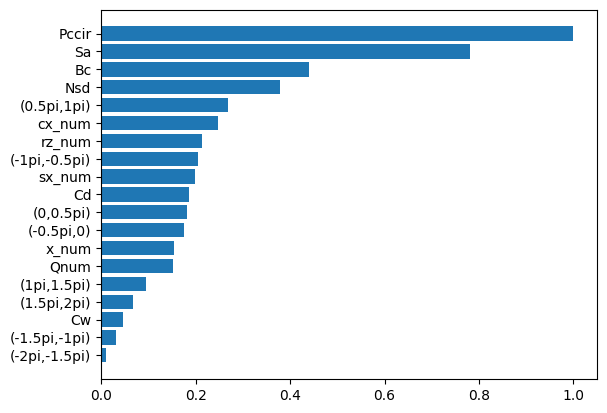

In [32]:
draw_from_dict(importance,21,1)

#### ② remove some feature data to test the feature importance

In [ ]:
test_path = './multi_backend_model_data/MQT_test'
test_loader_lists,X_test_lists,y_test_lists = get_test_data_by_qubit(test_path)

In [198]:
HLD_list_without_all,count_right_list = get_model_mited_test('forest_model_without_all',test_loader_lists,save = False)
print(HLD_list_without_all)
print(count_right_list)

[0.18963524529280554, 0.23862971138898662, 0.257488414435693, 0.352525564385253, 0.36756526473205725, 0.41116486430055005, 0.45967725577736945, 0.4837124275352785, 0.5094760526262108]
[0.8407738095238095, 0.8250564334085779, 0.830906620073772, 0.7923596411652051, 0.7950707918196119, 0.7856900260387184, 0.762667031513659, 0.7488326769255755, 0.6749097700184656]


In [26]:
# save test result
# save_HLD('RF_without_all',HLD_list_without_all)

#### ③test the complete QEMOS on MQT and random circuits

In [33]:
test_path = './multi_backend_model_data/MQT_test'
test_loader_lists,X_test_lists,y_test_lists = get_test_data_by_qubit(test_path)

C:\Users\30806\AppData\Local\Temp\ipykernel_62068\1317806438.py:188: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  qubits_used.add(qubit.index)  # 将比特索引添加到集合中
C:\Users\30806\AppData\Local\Temp\ipykernel_62068\1317806438.py:197: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  qubit_index = qubits[0].index  # 获取操作作用的比特索引
C:\Users\30806\AppData\Local\Temp\ipykernel_62068\1317806438.py:191: Depr

In [37]:
HLD_list,count_right_list = get_model_mited_test('QEMOS',test_loader_lists,save = False)
print(HLD_list)
print(count_right_list)

[0.18963524529280554, 0.23862971138898662, 0.257488414435693, 0.352525564385253, 0.36756526473205725, 0.41116486430055005, 0.45967725577736945, 0.4837124275352785, 0.5094760526262108]
[0.8407738095238095, 0.8250564334085779, 0.830906620073772, 0.7923596411652051, 0.7950707918196119, 0.7856900260387184, 0.762667031513659, 0.7488326769255755, 0.6749097700184656]


In [38]:
test_path = './multi_backend_model_data/test_data'
test_loader_lists,X_test_lists,y_test_lists = get_test_data_by_qubit(test_path)

C:\Users\30806\AppData\Local\Temp\ipykernel_62068\1317806438.py:188: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  qubits_used.add(qubit.index)  # 将比特索引添加到集合中
C:\Users\30806\AppData\Local\Temp\ipykernel_62068\1317806438.py:197: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  qubit_index = qubits[0].index  # 获取操作作用的比特索引
C:\Users\30806\AppData\Local\Temp\ipykernel_62068\1317806438.py:191: Depr

In [39]:
HLD_list,count_right_list = get_model_mited_test('QEMOS',test_loader_lists,save = False)
print(HLD_list)
print(count_right_list)

[0.05889191881910385, 0.08267630626741419, 0.12359939541812785, 0.1261327105160849, 0.16922793510890086, 0.1978145549749879, 0.2369909725998945, 0.24730696319718948, 0.27694254849841343, 0.2943744168931303, 0.3289606520868144, 0.34603783653025627]
[0.6208333333333333, 0.7481713688610241, 0.8300374131480491, 0.9122179416620804, 0.9235885308897428, 0.9249569168102773, 0.9196329824273952, 0.9235339210425451, 0.9240896018147203, 0.9306101299710695, 0.8640575437870639, 0.8439031154663955]


In [116]:
random_forest_HLD = {'random_forest':HLD_list}

In [117]:
print(random_forest_HLD)

{'random_forest': [0.05889191881910385, 0.08267630626741419, 0.12359939541812785, 0.1261327105160849, 0.16922793510890088, 0.1978145549749879, 0.2369909725998945, 0.24730696319718948, 0.27694254849841343, 0.2943744168931303, 0.3289606520868144, 0.34603783653025627]}


In [118]:
with open('./multi_backend_model_data/HLD.json', 'w') as file:
        json.dump(random_forest_HLD, file)

In [40]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

In [41]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
import ktrain
from ktrain import tabular
import os
import glob
import optuna
import pickle
import json

## Linear

In [11]:
# training Linear model
lr = LinearRegression(copy_X=True)
lr.fit(X_train.values, y_train.values)

LinearRegression()

In [19]:
model_name = 'Linear_model'
save_model(lr,model_name)

In [45]:
Linear_HLD_list,count_right_list = get_model_mited_test_other_model('Linear_model',test_loader_lists,save = False)
print(Linear_HLD_list)
print(count_right_list)

[0.04468800226530136, 0.07354612964706046, 0.11619452908902553, 0.12323400789576784, 0.1619965488842923, 0.19788318101811425, 0.2485976383576249, 0.3064903367468485, 0.5560586057555198, 0.6840459379782187, 0.7884668984783588, 0.8457399704280473]
[0.825, 0.832810867293626, 0.857830037413148, 0.9045129334067143, 0.8903340230564588, 0.8763904120319599, 0.8657272764510712, 0.6922192410885397, 0.09812181850096542, 0.09163608100522475, 0.10339953109915874, 0.10995809065976395]


In [121]:
save_HLD('Linear_model',Linear_HLD_list)

### Ridge

In [123]:
ridge = Ridge()
ridge.fit(X_train.values, y_train.values)

Ridge()

In [124]:
model_name = 'Ridge_model'
save_model(ridge,model_name)

In [49]:
Ridge_HLD_list,count_right_list = get_model_mited_test_other_model('Ridge_model',test_loader_lists,save = False)
print(Ridge_HLD_list)
print(count_right_list)

[0.04572736450146822, 0.0748652257435506, 0.11754077874440956, 0.12519437850528237, 0.1640786559658063, 0.20009228881556282, 0.25059577797173266, 0.30172133386386285, 0.549017302445089, 0.6827762045947329, 0.7899579329289815, 0.8487421728383395]
[0.825, 0.8296760710553814, 0.8610368786745056, 0.906989543203082, 0.8898906296186816, 0.8761554128152906, 0.8651538114938763, 0.7857656190111154, 0.09534032756781571, 0.09142881817004188, 0.10408909115984002, 0.11208437336291639]


In [188]:
print(Ridge_HLD_list)

[0.04572736450146822, 0.0748652257435506, 0.11754077874440956, 0.12519437850528237, 0.1640786559658063, 0.20009228881556282, 0.25059577797173266, 0.30172133386386285, 0.5490173024317782, 0.6827762045957844, 0.7899579329285537, 0.8487421728385934]


In [189]:
print(Linear_HLD_list)

[0.04468800226530136, 0.07354612964706046, 0.11619452908902553, 0.12323400789576784, 0.1619965488842923, 0.19788318101811425, 0.2485976383576249, 0.30649033675482473, 0.5560586057579939, 0.6840459379799323, 0.7884668984782514, 0.845739970427784]


In [128]:
save_HLD('Ridge_model',Ridge_HLD_list)

### SVR

In [55]:
svr = SVR()
svr.fit(X_train.values, y_train.values)

c:\Users\30806\.conda\envs\test\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [145]:
model_name = 'SVR_model'
save_model(svr,model_name)

In [57]:
SVR_HLD_list,count_right_list = get_model_mited_test_other_model_1('SVR_model',test_loader_lists,save = False)
print(SVR_HLD_list)
print(count_right_list)

[0.12049693727195866, 0.1868737620979194, 0.33732386185547253, 0.4591756650443507, 0.5842813004493351, 0.6830611031418492, 0.7629451951334104, 0.8230027500766987, 0.8743055440657657, 0.9020371092884136, 0.9155936230496985, 0.9273798874504353]
[0.08541666666666667, 0.07314524555903866, 0.05291288081239979, 0.03109521188772702, 0.04685190659178244, 0.06180479398402006, 0.083316265923893, 0.08405998466845535, 0.09412511308245905, 0.09537544798998229, 0.10620948834643497, 0.10959343831212187]


In [148]:
save_HLD('SVR_model',SVR_HLD_list)

## KNN

In [155]:
knnr = KNeighborsRegressor(n_neighbors=5)
knnr.fit(X_train.values, y_train.values)

KNeighborsRegressor()

In [156]:
model_name = 'KNN_model'
save_model(knnr,model_name)

In [58]:
KNN_HLD_list,count_right_list = get_model_mited_test_other_model('KNN_model',test_loader_lists,save = False)
print(KNN_HLD_list)
print(count_right_list)

[0.09536040257115659, 0.12437285261555033, 0.16976178184333404, 0.208005772335796, 0.31049444888149247, 0.4184768724195165, 0.5801338481979272, 0.6668565051383052, 0.7772238029560711, 0.7710915526288203, 0.8381541305643542, 0.8787333736992049]
[0.34375, 0.4315569487983281, 0.5505077498663816, 0.538800220143093, 0.46984924623115576, 0.4798684004386652, 0.4855609716134846, 0.5176312763510924, 0.5092153765139548, 0.446988211926249, 0.32773496759067716, 0.23295635470915124]


In [158]:
save_HLD('KNN_model',KNN_HLD_list)